# Large scale text analysis with deep learning

Today we're gonna apply the newly learned tools for the task of predicting job salary.

<img src="https://i0.wp.com/thecleverprogrammer.com/wp-content/uploads/2022/10/Salary-Prediction-with-Machine-Learning.png?fit=1920%2C1080&ssl=1" width=600px>


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### About the challenge
For starters, let's download and unpack the data from  the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (pick `Train_rev1.*`).

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_csv("/content/drive/MyDrive/sem2/Train_rev1.zip", compression='zip', index_col=None)
data.shape

(244768, 12)

In [393]:
data[15:25]

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
15,22579462,quality engineer,our client are a leading supplier of precision...,"Gateshead, Tyne and Wear",Gateshead,NaN,permanent,Other,Engineering Jobs,22000/annum,22000,cv-library.co.uk,9.998843
16,22581547,principal controls engineer,a leading subsea engineering company require a...,"Kent, South East",Kent,NaN,permanent,Other,Engineering Jobs,70000 - 100000/annum,85000,cv-library.co.uk,11.350418
17,22933091,chef de partie award winning dining live in sh...,a popular hotel located in norfolk which is a ...,Norfolk East Anglia,UK,NaN,NaN,Chef Results,Hospitality & Catering Jobs,"18,000 per annum + Tips (IRO 120 Per Month)",18000,caterer.com,9.798182
18,23528672,senior fatigue and damage tolerance engineer,senior fatigue static stress ( metallic or com...,"Avon, South West",Avon,NaN,permanent,Gregory Martin International,Engineering Jobs,34000 - 45000/annum to 45K,39500,cv-library.co.uk,10.584082
19,23529949,c i design engineer,we are currently recruiting on behalf of our c...,"Wolverhampton, West Midlands",Wolverhampton,NaN,permanent,Rullion Engineering Ltd,Engineering Jobs,33000 - 34000/annum + benefits,33500,cv-library.co.uk,10.419331
20,23530231,lead engineers ( stress ),lead engineers ( stress ) our client provide h...,"Bristol, Avon, South West, Avon",UK,NaN,permanent,Gregory Martin International,Engineering Jobs,34000 - 45000/annum,39500,cv-library.co.uk,10.584082
21,24104334,"relief chef de partie croydon , surrey live in",hotel and conference venue chain relief chef d...,South Croydon Surrey South East,UK,NaN,NaN,Towngate Personnel,Hospitality & Catering Jobs,Upto 9 per hour,17280,caterer.com,9.757363
22,24835524,senior control and instrumentation engineer,senior control and instrumentation engineer . ...,"Berkshire, South East",Berkshire,NaN,permanent,Gregory Martin International,Engineering Jobs,36000 - 47000/annum 36K-47K,41500,cv-library.co.uk,10.633472
23,24835548,control and instrumentation engineer,control and instrumentation engineer / c readi...,"Berkshire, South East",Berkshire,NaN,permanent,Gregory Martin International,Engineering Jobs,28000 - 35000/annum 28K-35K,31500,cv-library.co.uk,10.357775
24,24854800,electrical / ica engineer,electrical / ica engineer industry : environme...,"Surrey, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,"28000 - 37000/annum 28,000 to 37,000",32500,cv-library.co.uk,10.389026


One problem with salary prediction is that it's oddly distributed: there are many people who are paid standard salaries and a few that get tons o money. The distribution is fat-tailed on the right side, which is inconvenient for MSE minimization.

There are several techniques to combat this: using a different loss function, predicting log-target instead of raw target or even replacing targets with their percentiles among all salaries in the training set. We gonna use logarithm for now.

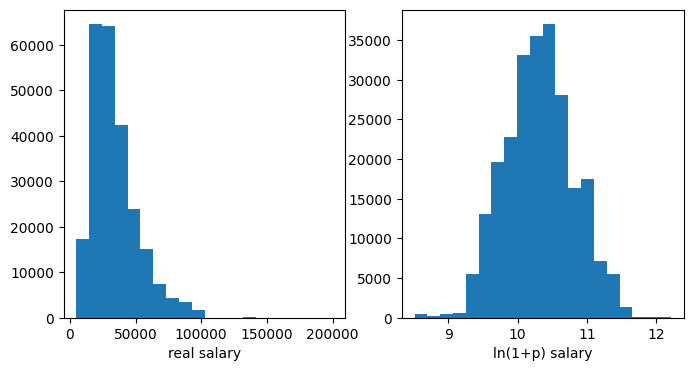

In [5]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20)
plt.xlabel('real salary');

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20)
plt.xlabel('ln(1+p) salary');

Our task is to predict one number, __Log1pSalary__.

To do so, our model can access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.

In [6]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
TARGET_COLUMN = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
24016,67638009,Regional Sales Manager : PPE and Gas Detectors,Job Title: Regional Sales Manager : PPE and Ga...,"Bristol, Southampton, Exeter, South West",UK,NaN,permanent,On Target Recruitment Ltd,Sales Jobs,40000 - 45000/annum 10k OTE,42500,cv-library.co.uk,10.657283
20772,67244553,SAS Risk Modelling Analyst Manchester,"Based in Manchester city centre, our client ha...",Manchester,Manchester,NaN,permanent,NaN,IT Jobs,GBP0 to GBP38000 per annum + Benefits: Bonus a...,19000,theitjobboard.co.uk,9.852247
188619,71693449,EMEA PRT Lead,US listed consultancy business seek a qualifie...,Redhill,Redhill,NaN,permanent,NaN,Consultancy Jobs,"70,000 - 80,000 + bonus + pension",75000,hays.co.uk,11.225257


### Preprocessing text data

First step is to lowercase and tokenize all texts under `Title` and `FullDescription` columns. Store the tokenized data as a __space-separated__ string of tokens for performance reasons.


In [7]:
print("Raw text:")
print(data["FullDescription"][2::100000])

Raw text:
2         Mathematical Modeller / Simulation Analyst / O...
100002    A successful and high achieving specialist sch...
200002    Web Designer  HTML, CSS, JavaScript, Photoshop...
Name: FullDescription, dtype: object


In [8]:
import nltk


tokenizer = nltk.tokenize.WordPunctTokenizer()
data["FullDescription"] = data["FullDescription"].apply(lambda x: ' '.join(tokenizer.tokenize(x.lower())))
data["Title"] = data["Title"].apply(lambda x: ' '.join(tokenizer.tokenize(str(x).lower())))

Now we can assume that our text is a space-separated list of tokens:

In [387]:
print("Tokenized:")
print(data["FullDescription"][2::100000])

Tokenized:
2         mathematical modeller / simulation analyst / o...
100002    a successful and high achieving specialist sch...
200002    web designer html , css , javascript , photosh...
Name: FullDescription, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times.

Let's count how many times is each word present in the data so that we can build a "white list" of known words.

In [10]:
from collections import Counter
token_counts = Counter()

for row in data['FullDescription'].values:
  token_counts.update(row.split())
for row in data['Title'].values:
  token_counts.update(row.split())

In [388]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('improvemen', 1)
('techniciancivil', 1)
('mlnlycke', 1)


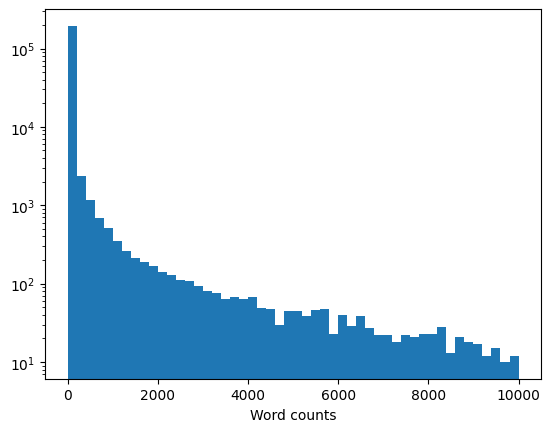

In [12]:
# Let's see how many words are there for each count
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts");

Get a list of all tokens that occur at least 10 times.

In [13]:
min_count = 10 #take the words that appers at least 10 times

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = sorted(t for t, c in token_counts.items() if c >= min_count)#TODO<YOUR CODE HERE>

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [389]:
print("Vocabulary size:", len(tokens))

Vocabulary size: 34158


Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [15]:
token_to_id = {tokens[index]:index for index in range(len(tokens))}

And finally, let's use the vocabulary you've built to map text lines into neural network-digestible matrices.

In [17]:
#UNK means "unknown token" - is used to replace the rare words that did not fit in your vocabulary
#PAD - all batch should have the same length to fit the maximum sequence length: if the string's length is less then max the it would be filled with _pad_ _pad_ _pad_...
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))

    max_len = min(max(map(len, sequences)), max_len or float('inf'))

    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix

    return matrix

In [18]:
print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Lines:
engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[10807 30161  2166     1     1]
 [15020  2844     1     1     1]
 [27645 10201    16 15215 10804]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement more advanced encodings: tf-idf, pseudo-time-series, etc.

In [19]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

### The deep learning part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [20]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  195814
Validation size =  48954


In [21]:
import torch
import torch.nn as nn
import torch.functional as F


device = 'cuda' if torch.cuda.is_available() else 'cpu'


def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["FullDescription", "Title"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors


def make_batch(data, max_len=None, word_dropout=0, device=device):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))

    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)

    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values

    return to_tensors(batch, device)

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

#### Architecture

Our basic model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/nlp_course/raw/master/resources/w2_conv_arch.png)

This clearly doesn't fit into keras' __Sequential__ interface. To build such a network, one will have to use PyTorch.

In [195]:
class GlobalMaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim

    def forward(self, x):
        return x.max(dim=self.dim)[0]

In [380]:
class SalaryPredictor(nn.Module):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
        super().__init__()

        #title encoder: emb -> conv -> pool
        self.emb_title = nn.Embedding(n_tokens, hid_size)
        self.conv_title = nn.Conv1d(hid_size, hid_size, 3)
        self.pool_title = GlobalMaxPooling()
        self.linear_title = nn.Linear(hid_size, hid_size)

        #descr encoder: emb -> conv -> pool
        self.emb_descr = nn.Embedding(n_tokens, hid_size)
        self.conv_descr = nn.Conv1d(hid_size, hid_size, 3)
        self.pool_descr = GlobalMaxPooling()
        self.linear_descr = nn.Linear(hid_size, hid_size)

        #categorical encoder
        self.cat_encoder = nn.Sequential(
            nn.Linear(n_cat_features, 256),
            nn.ReLU(),
            nn.Linear(256, hid_size)
        )

        self.out_layers = nn.Sequential(
            nn.Linear(192, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )

    def forward(self, batch):

        t = self.emb_title(batch['Title'])
        t = torch.transpose(t, 1, 2)
        t = self.conv_title(t)
        t = self.pool_title(t)
        t = nn.ReLU()(t)
        t = self.linear_title(t)

        d = self.emb_descr(batch['FullDescription'])
        d = torch.transpose(d, 1, 2)
        d = self.conv_descr(d)
        d = self.pool_descr(d)
        d = nn.ReLU()(d)
        d = self.linear_descr(d)

        cat = self.cat_encoder(batch['Categorical'])

        concat = torch.cat([t, d, cat], dim=1)

        out = self.out_layers(concat)

        return out[:,0]

In [385]:
model = SalaryPredictor().to(device)
batch = make_batch(data_train[:100])
criterion = nn.MSELoss()

dummy_pred = model(batch)
dummy_loss = criterion(dummy_pred, batch[TARGET_COLUMN])
assert dummy_pred.shape == torch.Size([100])
assert len(torch.unique(dummy_pred)) > 20, "model returns suspiciously few unique outputs. Check your initialization"
assert dummy_loss.ndim == 0 and 0. <= dummy_loss <= 250., "make sure you minimize MSE"

#### Training and evaluation

As usual, we gonna feed our monster with random minibatches of data.

As we train, we want to monitor not only loss function, which is computed in log-space, but also the actual error measured in dollars.

In [386]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, device=device, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], device=device, **kwargs)
            yield batch

        if not cycle: break

### Model training

We can now fit our model the usual minibatch way. The interesting part is that we train on an infinite stream of minibatches, produced by `iterate_minibatches` function.

In [69]:
from tqdm.auto import tqdm

BATCH_SIZE = 16
EPOCHS = 20

In [70]:
maee = []
msee = []

In [71]:
def print_metrics(model, data, batch_size=BATCH_SIZE, name="", device=torch.device('cpu'), **kw):
    squared_error = abs_error = num_samples = 0.0
    model.eval()
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, device=device, **kw):
            batch_pred = model(batch)
            squared_error += torch.sum(torch.square(batch_pred - batch[TARGET_COLUMN]))
            abs_error += torch.sum(torch.abs(batch_pred - batch[TARGET_COLUMN]))
            num_samples += len(batch_pred)
    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % mse)
    print("Mean absolute error: %.5f" % mae)
    maee.append(mae)
    msee.append(mse)
    return mse, mae


In [72]:
model = SalaryPredictor().to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model.train()
    for i, batch in tqdm(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=device)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print_metrics(model, data_val, device=device)



epoch: 0


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.14170
Mean absolute error: 0.28975
epoch: 1


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.12974
Mean absolute error: 0.28063
epoch: 2


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.12706
Mean absolute error: 0.27928
epoch: 3


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.10275
Mean absolute error: 0.24142
epoch: 4


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.11632
Mean absolute error: 0.26625
epoch: 5


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.09433
Mean absolute error: 0.23111
epoch: 6


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.09875
Mean absolute error: 0.23763
epoch: 7


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.08847
Mean absolute error: 0.22416
epoch: 8


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.08638
Mean absolute error: 0.22112
epoch: 9


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.10885
Mean absolute error: 0.25825
epoch: 10


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.09032
Mean absolute error: 0.22954
epoch: 11


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.08274
Mean absolute error: 0.21596
epoch: 12


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.08843
Mean absolute error: 0.22498
epoch: 13


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.09637
Mean absolute error: 0.24034
epoch: 14


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.08373
Mean absolute error: 0.21954
epoch: 15


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.08874
Mean absolute error: 0.22820
epoch: 16


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.07848
Mean absolute error: 0.20994
epoch: 17


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.07937
Mean absolute error: 0.21146
epoch: 18


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.07682
Mean absolute error: 0.20810
epoch: 19


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.09592
Mean absolute error: 0.24042


### Bonus part: explaining model predictions

It's usually a good idea to understand how your model works before you let it make actual decisions. It's simple for linear models: just see which words learned positive or negative weights. However, its much harder for neural networks that learn complex nonlinear dependencies.

There are, however, some ways to look inside the black box:
* Seeing how model responds to input perturbations
* Finding inputs that maximize/minimize activation of some chosen neurons (_read more [on distill.pub](https://distill.pub/2018/building-blocks/)_)
* Building local linear approximations to your neural network: [article](https://arxiv.org/abs/1602.04938), [eli5 library](https://github.com/TeamHG-Memex/eli5/tree/master/eli5/formatters)

Today we gonna try the first method just because it's the simplest one.

In [ ]:
def explain(model, sample, col_name='Title'):
    """ Computes the effect each word had on model predictions """
    sample = dict(sample)
    sample_col_tokens = [tokens[token_to_id.get(tok, 0)] for tok in sample[col_name].split()]
    data_drop_one_token = pd.DataFrame([sample] * (len(sample_col_tokens) + 1))

    for drop_i in range(len(sample_col_tokens)):
        data_drop_one_token.loc[drop_i, col_name] = ' '.join(UNK if i == drop_i else tok
                                                   for i, tok in enumerate(sample_col_tokens))

    *predictions_drop_one_token, baseline_pred = model(make_batch(data_drop_one_token, device=device)).detach().cpu()
    diffs = baseline_pred - torch.Tensor(predictions_drop_one_token)
    return list(zip(sample_col_tokens, diffs))

In [ ]:
from IPython.display import HTML, display_html


def draw_html(tokens_and_weights, cmap=plt.get_cmap("bwr"), display=True,
              token_template="""<span style="background-color: {color_hex}">{token}</span>""",
              font_style="font-size:14px;"
             ):

    def get_color_hex(weight):
        rgba = cmap(1. / (1 + np.exp(float(weight))), bytes=True)
        return '#%02X%02X%02X' % rgba[:3]

    tokens_html = [
        token_template.format(token=token, color_hex=get_color_hex(weight))
        for token, weight in tokens_and_weights
    ]


    raw_html = """<p style="{}">{}</p>""".format(font_style, ' '.join(tokens_html))
    if display:
        display_html(HTML(raw_html))

    return raw_html


In [ ]:
i = 36605
tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

sales specialist iv access and infusion

sales representative medical sales iv access and infusion an opportunity to work for the industry leading manufacturer of iv access and infusion solutions . formally recognised as the number **** company in this market space , our client are an ethical and dynamic organisation absolutely committed to the advancement of innovative technologies . job title : sales specialist iv access and infusion selling : medication delivery solutions selling to : iv teams , infection control , lead intensive care nurse specialists , ward managers territory : east midlands location : east midlands package : basic : **** k **** k , uncapped bonus in addition , full corporate benefits company information hugely ethical and professional global organisation extremely well established in the uk the market leader across all of their core business areas focus on providing cutting edge solutions along with outstanding service and support a business that retain talented personnel by offering a strong platform for career development sales specialist iv access and infusion you must have / be the following at least 2 years medical device sales experience . candidates who have sold disposables / consumables or similar into hospitals would be of particular interest . candidates must have sold into hospitals demonstrable performance and achievements so far personable , adaptable and willing to learn keen and eager to be a success candidates must have a degree or at least be able to show a strong ability to learn role information managing the east midlands region selling across the company ' s range of iv and infusion solutions portfolio selling into lead intensive care nurse specialists , ward managers , iv teams , infection control teams , procurement sales specialist iv access and infusion candidates must be eligible to work and live in the uk . please contact allan waller on **** **** **** or please hit the apply button . this job was originally posted as www . salestarget . co . uk / jobseeking / UNK ****

In [ ]:
i = 11077
tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

international music / live event sales graduate role , start early jan **** k (**** kote )

music / live event sales graduate role , start early jan **** k (**** kote ) music / live events delegate sales **** x graduate positions , trainee sales executive UNK the company UNK they are an international live events business looking to expand after recent success in graduate programs . the company itself offers many opportunities in many areas and the company is growing products and expanding in to new markets and regions all the time . they have recently been UNK to win the top company to work for in 2012 and are widely considered to be the most advanced live events sales company in the uk . UNK the team UNK full of lively characters , and passionate sales people they only employ the top candidates . a top candidate is charismatic , hardworking and driven to succeed . they like to enjoy their work space as much as they enjoy making money . with the ethos work hard , play hard they keep the team happy with **** trips away every year ( this year ; france , spain , turkey and ireland ). it s an open plan office where everyone gets the chance to interact while they work . UNK the role UNK you will be working directly with senior level executives and ceo s pulling them into live events . some of the responsibilities are : maximise all potential sales on the event by executing current sales plans , contributing ideas to develop their shows read the trade press , exploit knowledge to spot new opportunities project managing show features sponsorship fulfilment manage and monitor the floor plan by checking to ensure it is current and accurate new business sourcing and selling manage existing exhibitor accounts effectively visiting competitive shows liaising with other internal departments / functions marketing , operations , conferences , accounts pr etc . in order to apply for this submit your cv as soon as possible . applicants will be called by a team of trained recruiters and asked about their motivations and interests .

In [ ]:
i = np.random.randint(len(data))
print("Index:", i)
print("Salary (gbp):", np.expm1(model(make_batch(data.iloc[i: i+1], device=device)).detach().cpu()))

tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

Index: 49190
Salary (gbp): tensor([8146.5161])


sustrans street team leader ****/ hour

don ' t let the world pass you by stop and talk to them instead we need passionate , enthusiastic and experienced team leaders or fundraisers to help us gain new supporters to help in the development of the national cycle network . you are be working on the streets of london and the surrounding area , talking to the public about sustrans and inspiring them to join the cause a passion for what we do , excellent team leading skills , experience in street fundraising , a sense of humour and an inspirational character is a must for this position . you will manage up to 6 fundraisers that will be based around london . monday friday , 10am 6pm and 10 / hour email us your cv and we ' ll call you right back

__Terrible start-up idea #1962:__ make a tool that automaticaly rephrases your job description (or CV) to meet salary expectations :)

#PLOTS FOR DIFFERENT NN

        #title encoder: emb -> conv -> pool
        self.emb_title = nn.Embedding(n_tokens, hid_size)
        self.conv_title = nn.Conv1d(hid_size, hid_size, 3)
        self.pool_title = GlobalMaxPooling()
        self.linear_title = nn.Linear(hid_size, hid_size)

        #descr encoder: emb -> conv -> pool
        self.emb_descr = nn.Embedding(n_tokens, hid_size)
        self.conv_descr = nn.Conv1d(hid_size, hid_size, 3)
        self.pool_descr = GlobalMaxPooling()
        self.linear_descr = nn.Linear(hid_size, hid_size)

        #categorical encoder
        self.cat_encoder = nn.Sequential(
            nn.Linear(n_cat_features, 256),
            nn.ReLU(),
            nn.Linear(256, hid_size)
        )

        self.out_layers = nn.Sequential(
            nn.Linear(192, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )

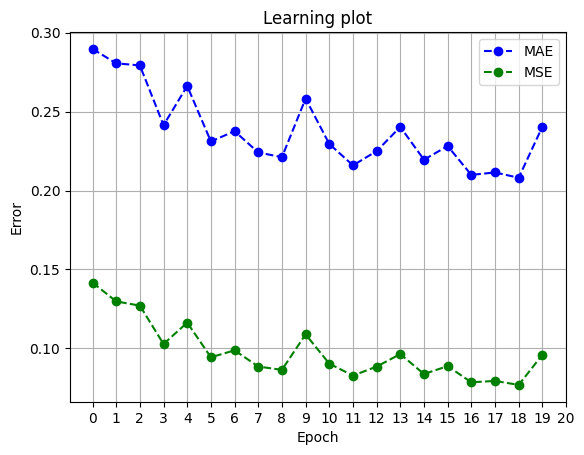

In [73]:
# Create plot
plt.plot(maee, color='blue', marker='o', linestyle='--', label="MAE")
plt.plot(msee, color='green', marker='o', linestyle='--', label="MSE")
# Add title and labels
plt.title('Learning plot')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.xticks(range(0, EPOCHS+1, 1))
plt.legend(loc="upper right")
# Add grid
plt.grid(True)